In [1]:
import copy
import numpy as np
import pandas as pd
import pickle
import time
from catboost import Pool, CatBoostRegressor
from collections import defaultdict
from progiter import ProgIter
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from time import time as t
from imp import reload
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import sys
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from os import walk, chdir, getcwd
from datetime import datetime
from scipy.stats import iqr, wilcoxon, normaltest, sem, t
from arch.bootstrap import IIDBootstrap



sns.set_style('dark')
warnings.filterwarnings('ignore')

from mymodule import make_combo_fp, predict_synergy

In [2]:
from rdkit import Chem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles

In [9]:
with open('/tf/notebooks/code_for_pub/smiles_files/smiles_drugcomb_BY_cid_duplicated.pickle','rb') as f:
    b = pickle.load(f)
    b = pd.DataFrame(b).drop_duplicates()
drugs_name = '/tf/notebooks/code_for_pub/smiles_files/drugcomb_drugs_export_OCT2020.csv'
drugs = pd.read_csv(drugs_name, names=['dname','id', 'smiles', 'cid'], header=0) # oct2020 version

mapping = defaultdict(list) 
for i in drugs.itertuples(): # map cid to id
    mapping[i.cid] = i.id
b['id'] = b.index
b['id'] = b['id'].map(mapping)
b = b.set_index('id', drop=True)
b = b.iloc[:,0]

In [10]:
def mcs_split(data = b, seed = 2,frac_train=0.8,frac_valid=0.1,frac_test=0.1, includeChirality=False):
    scaffolds={}
    for ind,smiles in b.iteritems():
        mol = Chem.MolFromSmiles(smiles)
        scaffold = MurckoScaffoldSmiles(mol=mol, includeChirality=includeChirality)
        if scaffold not in scaffolds:
            scaffolds[scaffold] = [ind]
        else:
            scaffolds[scaffold].append(ind)
    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}
    scaffold_sets = [scaffold_set for (scaffold, scaffold_set) \
                     in sorted(scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)]
    frac_train: float = 0.8
    frac_valid: float = 0.1
    frac_test: float = 0.1

    train_cutoff = frac_train * len(b)
    valid_cutoff = (frac_train + frac_valid) * len(b)
    train_inds = []
    valid_inds = []
    test_inds = []
    
    for scaffold_set in scaffold_sets:
      if len(train_inds) + len(scaffold_set) > train_cutoff:
        if len(train_inds) + len(valid_inds) + len(scaffold_set) > valid_cutoff:
          test_inds += scaffold_set
        else:
          valid_inds += scaffold_set
      else:
        train_inds += scaffold_set
    return train_inds, valid_inds, test_inds, scaffold_sets

In [11]:
test = mcs_split(b)

<AxesSubplot:ylabel='Density'>

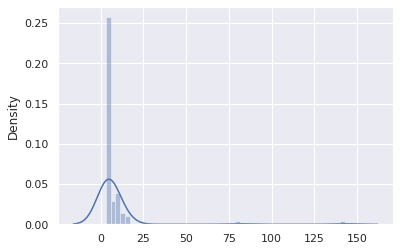

In [34]:
sns.set()
sns.distplot([len(x) for x in test[3]][:100], hist=True, kde=True,)